# Forecasting with Temporal Fusion Transformers

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import holidays
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import pandas as pd
import pickle
import random

from datetime import date
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from sklearn.metrics import mean_absolute_error

"Reproducible" results

In [2]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    #torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [3]:
set_seed(42)

Set the float32 matmul precision to high to speed up computation

In [4]:
torch.set_float32_matmul_precision('medium')

Read the dataframe

In [5]:
df = pd.read_csv('../data/renfe_tft/output.csv')
print(f'Number of passengers: {len(df)}')
df.head()

Number of passengers: 1903059


,id,user_pattern,departure_station,arrival_station,arrival_day,arrival_time,purchase_day,service,service_departure_time,service_arrival_time,seat,price,utility,best_service,best_seat,best_utility
0,540436,Business,60000,71801,2023-04-19,9.801870,10,03063_19-04-2023-06.30,6.5,9.333333,Premium,82.70,3.490407,03063_19-04-2023-06.30,Premium,3.490407
1,64250,Business,60000,71801,2023-01-10,8.662733,9,03063_10-01-2023-06.30,6.5,9.333333,Premium,106.93,2.631496,03063_10-01-2023-06.30,Premium,2.631496
2,1042878,Business,60000,71801,2023-07-18,6.508191,9,03063_18-07-2023-06.30,6.5,9.333333,Premium,118.20,0.586648,03063_18-07-2023-06.30,Premium,0.586648
3,1227283,Business,60000,71801,2023-08-14,6.519566,9,03063_14-08-2023-06.30,6.5,9.333333,Elige,34.58,1.042780,03063_14-08-2023-06.30,Elige,1.042780
4,1451801,Business,60000,71801,2023-09-27,7.633192,9,03063_27-09-2023-06.30,6.5,9.333333,Premium,93.98,2.528534,03063_27-09-2023-06.30,Premium,2.528534


Drop passengers that don't buy a ticket

In [6]:
df = df[df['service'].notna()]
print(f'Number of passengers: {len(df)}')

Number of passengers: 649533


Convert arrival_day to datetime

In [7]:
df['arrival_day'] = pd.to_datetime(df['arrival_day'])

Group the passengers per seat and arrival day to get the number of tickets sold

In [8]:
df_ticket_sold = df.groupby(by=['seat', 'arrival_day']).size().to_frame()
df_ticket_sold.columns = ['tickets_sold']
df_ticket_sold

tickets_sold
seat    arrival_day              
Basico  2023-01-01           2535
        2023-01-02            909
        2023-01-03           1590
        2023-01-04            955
        2023-01-05           1364
...                           ...
Premium 2023-12-27            183
        2023-12-28            190
        2023-12-29            653
        2023-12-30            180
        2023-12-31            394

[1095 rows x 1 columns]

Convert tickets sold to float

In [9]:
df_ticket_sold['tickets_sold'] = df_ticket_sold['tickets_sold'].astype(float)

Group the passegners per seat and arrival day to get the mean price and utility

In [10]:
df_price_utility = df.groupby(by=['seat', 'arrival_day'])[['price', 'utility']].mean()
df_price_utility.columns = ['price', 'user_satisfaction']
df_price_utility

price  user_satisfaction
seat    arrival_day                               
Basico  2023-01-01    47.266722           3.606632
        2023-01-02    26.343828           4.120224
        2023-01-03    37.108975           2.203665
        2023-01-04    25.393738           3.881862
        2023-01-05    31.900374           2.081171
...                         ...                ...
Premium 2023-12-27   110.925027           1.912853
        2023-12-28   124.815579           1.426228
        2023-12-29   137.509127          10.623778
        2023-12-30   118.847667          11.459708
        2023-12-31   153.454086          10.938670

[1095 rows x 2 columns]

Concat the previous dataframes

In [11]:
df = pd.concat([df_ticket_sold, df_price_utility], axis=1)
df

tickets_sold       price  user_satisfaction
seat    arrival_day                                             
Basico  2023-01-01         2535.0   47.266722           3.606632
        2023-01-02          909.0   26.343828           4.120224
        2023-01-03         1590.0   37.108975           2.203665
        2023-01-04          955.0   25.393738           3.881862
        2023-01-05         1364.0   31.900374           2.081171
...                           ...         ...                ...
Premium 2023-12-27          183.0  110.925027           1.912853
        2023-12-28          190.0  124.815579           1.426228
        2023-12-29          653.0  137.509127          10.623778
        2023-12-30          180.0  118.847667          11.459708
        2023-12-31          394.0  153.454086          10.938670

[1095 rows x 3 columns]

Add missing dates and seats

In [12]:
df = df.unstack().fillna(0).stack()
df

tickets_sold       price  user_satisfaction
seat    arrival_day                                             
Basico  2023-01-01         2535.0   47.266722           3.606632
        2023-01-02          909.0   26.343828           4.120224
        2023-01-03         1590.0   37.108975           2.203665
        2023-01-04          955.0   25.393738           3.881862
        2023-01-05         1364.0   31.900374           2.081171
...                           ...         ...                ...
Premium 2023-12-27          183.0  110.925027           1.912853
        2023-12-28          190.0  124.815579           1.426228
        2023-12-29          653.0  137.509127          10.623778
        2023-12-30          180.0  118.847667          11.459708
        2023-12-31          394.0  153.454086          10.938670

[1095 rows x 3 columns]

Reset the index of the dataframe

In [13]:
df = df.reset_index()
df

,seat,arrival_day,tickets_sold,price,user_satisfaction
0,Basico,2023-01-01,2535.0,47.266722,3.606632
1,Basico,2023-01-02,909.0,26.343828,4.120224
2,Basico,2023-01-03,1590.0,37.108975,2.203665
3,Basico,2023-01-04,955.0,25.393738,3.881862
4,Basico,2023-01-05,1364.0,31.900374,2.081171
...,...,...,...,...,...
1090,Premium,2023-12-27,183.0,110.925027,1.912853
1091,Premium,2023-12-28,190.0,124.815579,1.426228
1092,Premium,2023-12-29,653.0,137.509127,10.623778
1093,Premium,2023-12-30,180.0,118.847667,11.459708


Define the calendars

In [14]:
class CalendarLocalMadrid(holidays.HolidayBase):
    
    def _populate(self, year):
        self[date(year, 5, 15)] = 'San Isidro Labrador Patrón de Madrid'
        self[date(year, 11, 9)] = 'Día de Nuestra Señora de la Almudena'

In [15]:
class CalendarRegionalMadrid(holidays.HolidayBase):
    
    def _populate(self, year):
        self[date(year, 3, 20)] = 'San José'
        self[date(year, 5, 2)] = 'Fiesta de la Comunidad de Madrid'

In [16]:
class CalendarLocalBCN(holidays.HolidayBase):
    
    def _populate(self, year):
        self[date(year, 5, 29)] = 'Lunes de Pascua Granada'
        self[date(year, 9, 25)] = 'Dilluns següent a la Mercè'

In [17]:
class CalendarRegionalBCN(holidays.HolidayBase):
    
    def _populate(self, year):
        self[date(year, 4, 10)] = 'Lunes de Pascua'
        self[date(year, 6, 24)] = 'Sant Joan'

In [18]:
class CalendarOrange(holidays.HolidayBase):

    def _populate(self, year):
        self[date(year, 5, 27)] = 'Orange'
        self[date(year, 5, 28)] = 'Orange'
        self[date(year, 9, 15)] = 'Orange'
        self[date(year, 9, 16)] = 'Orange'

Add to the dataframe new features

In [19]:
# Add time features
df['month'] = df['arrival_day'].dt.month
df['day'] = df['arrival_day'].dt.day
df['weekday'] = df['arrival_day'].dt.weekday
df['days_from_start'] = (df['arrival_day'] - df['arrival_day'].min()).dt.days

# Add holiday features
es_holidays = holidays.ES()
madrid_local = CalendarLocalMadrid()
madrid_regional = CalendarRegionalMadrid()
bcn_local = CalendarLocalBCN()
bcn_regional = CalendarRegionalBCN()
orange = CalendarOrange()
df['national_holiday'] = df['arrival_day'].apply(lambda x: es_holidays.get(x) if x in es_holidays else 'X')
df['regional_holiday'] = df['arrival_day'].apply(lambda x: madrid_regional.get(x) if x in madrid_regional else bcn_regional.get(x) if x in bcn_regional else 'X')
df['local_holiday'] = df['arrival_day'].apply(lambda x: madrid_local.get(x) if x in madrid_local else bcn_local.get(x) if x in bcn_local else 'X')
df['meteorological_warnings'] = df['arrival_day'].apply(lambda x: orange.get(x) if x in orange else 'X')
df

,seat,arrival_day,tickets_sold,price,user_satisfaction,month,day,weekday,days_from_start,national_holiday,regional_holiday,local_holiday,meteorological_warnings
0,Basico,2023-01-01,2535.0,47.266722,3.606632,1,1,6,0,X,X,X,X
1,Basico,2023-01-02,909.0,26.343828,4.120224,1,2,0,1,X,X,X,X
2,Basico,2023-01-03,1590.0,37.108975,2.203665,1,3,1,2,X,X,X,X
3,Basico,2023-01-04,955.0,25.393738,3.881862,1,4,2,3,X,X,X,X
4,Basico,2023-01-05,1364.0,31.900374,2.081171,1,5,3,4,X,X,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,Premium,2023-12-27,183.0,110.925027,1.912853,12,27,2,360,X,X,X,X
1091,Premium,2023-12-28,190.0,124.815579,1.426228,12,28,3,361,X,X,X,X
1092,Premium,2023-12-29,653.0,137.509127,10.623778,12,29,4,362,X,X,X,X
1093,Premium,2023-12-30,180.0,118.847667,11.459708,12,30,5,363,X,X,X,X


Exploratory data analysis

In [20]:
df[['seat', 'tickets_sold']].groupby(by='seat').mean()

,tickets_sold
seat,
Basico,1233.454795
Elige,262.816438
Premium,283.271233


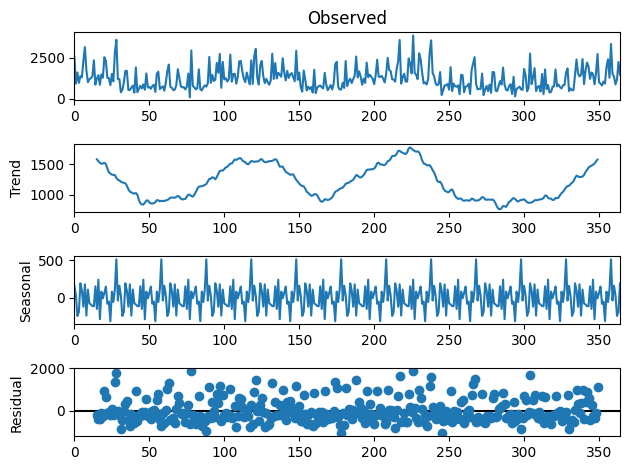

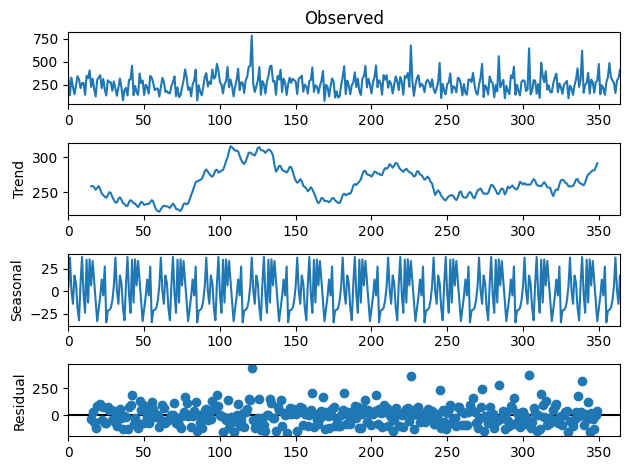

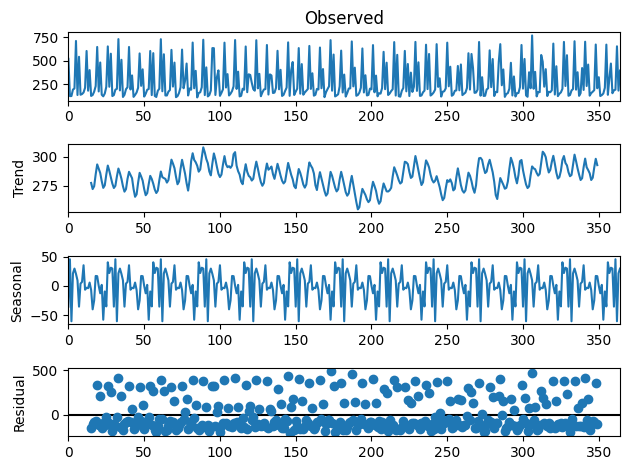

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = [value[0] for value in df[df['seat'] == 'Basico'][['tickets_sold']].values.tolist()]
result = seasonal_decompose(series, model='additive', period=30).plot()

series = [value[0] for value in df[df['seat'] == 'Elige'][['tickets_sold']].values.tolist()]
result = seasonal_decompose(series, model='additive', period=30).plot()

series = [value[0] for value in df[df['seat'] == 'Premium'][['tickets_sold']].values.tolist()]
result = seasonal_decompose(series, model='additive', period=30).plot()

Create training and validation time series dataset

In [22]:
min_prediction_length = 1 # We want to predict the next day
max_prediction_length = 7 # We want to predict the next 7 days
max_encoder_length = 30 # We want to use 30 days of data to predict the next 7 days
training_cutoff = df['days_from_start'].max() - max_prediction_length

As validation set have 'Navidad' and it is not present in the training set, we set 'Navidad' to the nearest national holiday

In [23]:
df.loc[df['arrival_day'] == '2023-12-25', 'national_holiday'] = 'Día de la Constitución Española'

In [24]:
training = TimeSeriesDataSet(
    df[lambda x: x.days_from_start <= training_cutoff],
    time_idx='days_from_start',
    target='tickets_sold',
    group_ids=['seat'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['seat', 'national_holiday', 'regional_holiday', 'local_holiday', 'meteorological_warnings'],
    time_varying_known_reals=['days_from_start', 'day', 'weekday', 'month', 'price', 'user_satisfaction'],
    time_varying_unknown_reals=['tickets_sold'],
    target_normalizer=GroupNormalizer(groups=['seat'], transformation='softplus'),
    #categorical_encoders={'national_holiday': NaNLabelEncoder(add_nan=True)},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

In [25]:
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

In [26]:
# Create dataloaders for our model
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=16)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=16)

In [27]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).cpu()
baseline_predictions = Baseline().predict(val_dataloader).cpu()
mae = mean_absolute_error(actuals, baseline_predictions)
print(f'Baseline MAE: {mae}')

/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Baseline MAE: 308.38092041015625


Train the TFT model

In [27]:
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=True, mode='min')
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger('lightning_logs')  

trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4
)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
Missing logger folder: lightning_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
---------------------------

Sanity Checking: 0it [00:00, ?it/s]

/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 140.676


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 32.169 >= min_delta = 0.0001. New best score: 108.507


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 13.967 >= min_delta = 0.0001. New best score: 94.540


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.658 >= min_delta = 0.0001. New best score: 90.881


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.083 >= min_delta = 0.0001. New best score: 87.799


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.790 >= min_delta = 0.0001. New best score: 87.008


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.244 >= min_delta = 0.0001. New best score: 85.764


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.744 >= min_delta = 0.0001. New best score: 84.020


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.382 >= min_delta = 0.0001. New best score: 79.639


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.356 >= min_delta = 0.0001. New best score: 77.283


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.336 >= min_delta = 0.0001. New best score: 69.947


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.756 >= min_delta = 0.0001. New best score: 68.192


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.102 >= min_delta = 0.0001. New best score: 59.090


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 18.030 >= min_delta = 0.0001. New best score: 41.060


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 41.060. Signaling Trainer to stop.


In [28]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).cpu()
predictions = tft.predict(val_dataloader).cpu()
mae = mean_absolute_error(actuals, predictions)
print(f'Baseline MAE: {mae}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Baseline MAE: 97.61430358886719


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


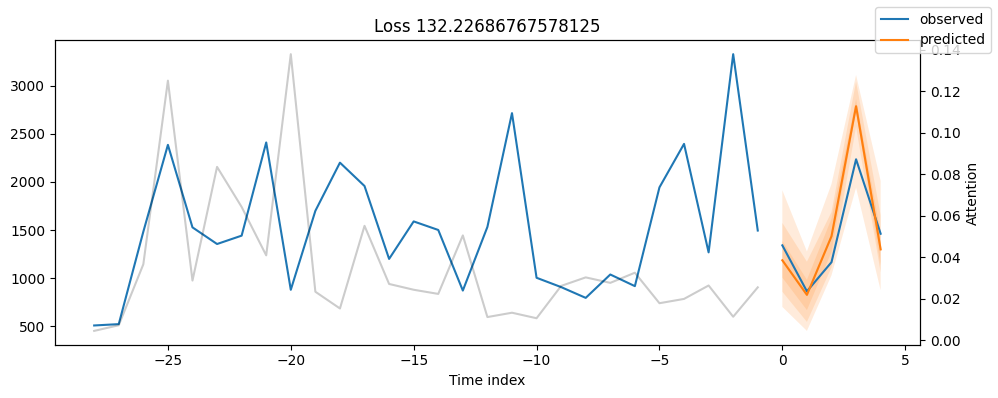

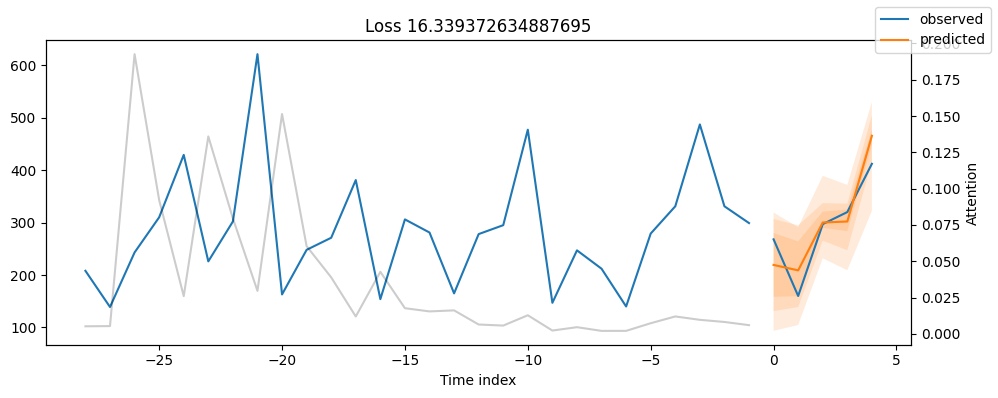

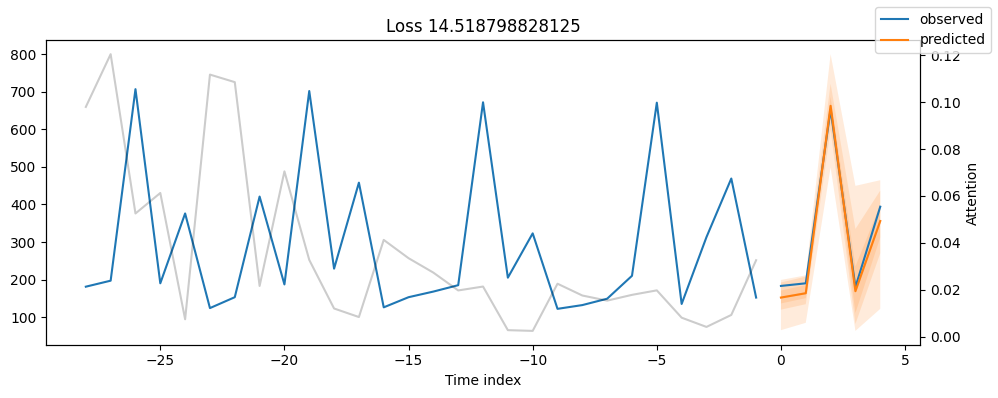

In [29]:
raw_predictions = tft.predict(val_dataloader, mode='raw', return_x=True)
for idx in range(3):
    fig, ax = plt.subplots(figsize=(10, 4))
    tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True, ax=ax)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x400 with 1 Axes>,
 'encoder_variables': <Figure size 700x400 with 1 Axes>,
 'decoder_variables': <Figure size 700x375 with 1 Axes>}

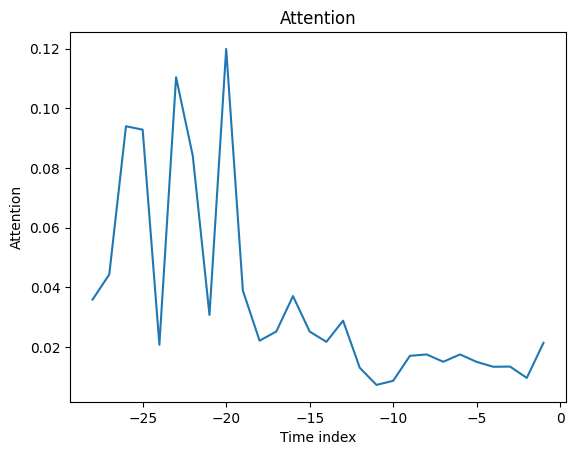

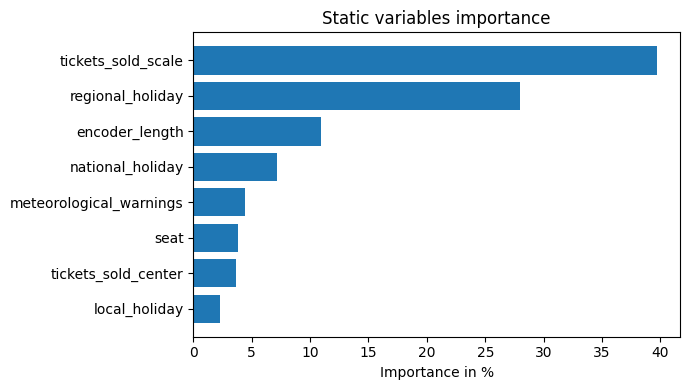

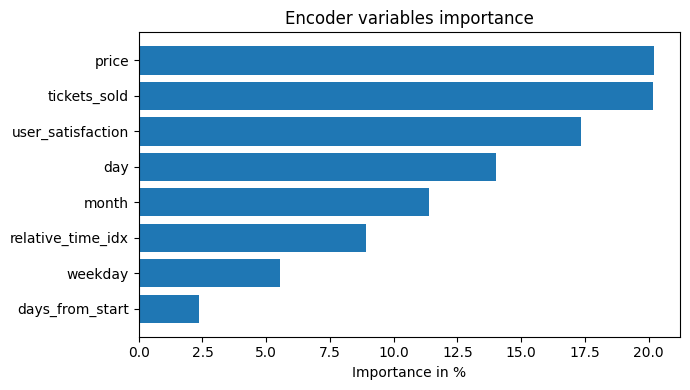

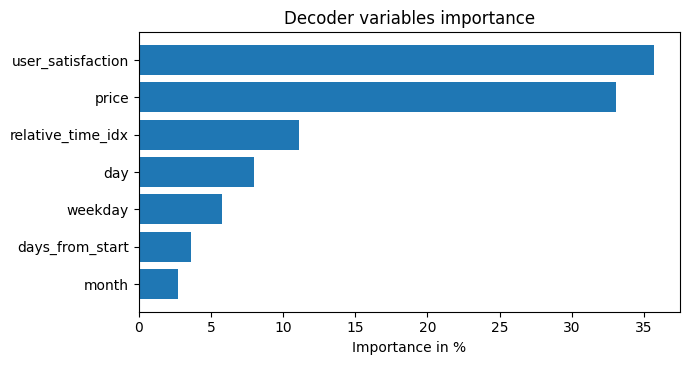

In [30]:
interpretation = tft.interpret_output(raw_predictions.output, reduction='sum')
tft.plot_interpretation(interpretation)

Analysis on the validation set

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/pytorch_forecasting/models/base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/pytorch_forecasting/models/base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/pytorch_forecasting/models/base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'tickets_sold_center': <Figure size 1000x500 with 2 Axes>,
 'tickets_sold_scale': <Figure size 1000x500 with 2 Axes>,
 'days_from_start': <Figure size 1000x500 with 2 Axes>,
 'day': <Figure size 1000x500 with 2 Axes>,
 'weekday': <Figure size 1000x500 with 2 Axes>,
 'month': <Figure size 1000x500 with 2 Axes>,
 'price': <Figure size 1000x500 with 2 Axes>,
 'user_satisfaction': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'tickets_sold': <Figure size 1000x500 with 2 Axes>,
 'seat': <Figure size 640x480 with 2 Axes>,
 'national_holiday': <Figure size 1000x500 with 2 Axes>,
 'regional_holiday': <Figure size 640x480 with 2 Axes>,
 'local_holiday': <Figure size 640x480 with 2 Axes>,
 'meteorological_warnings': <Figure size 640x480 with 2 Axes>}

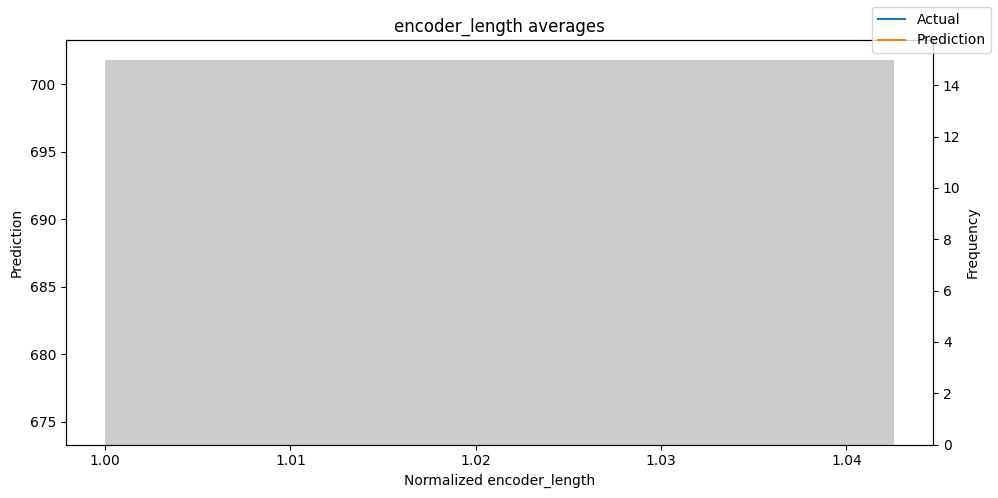

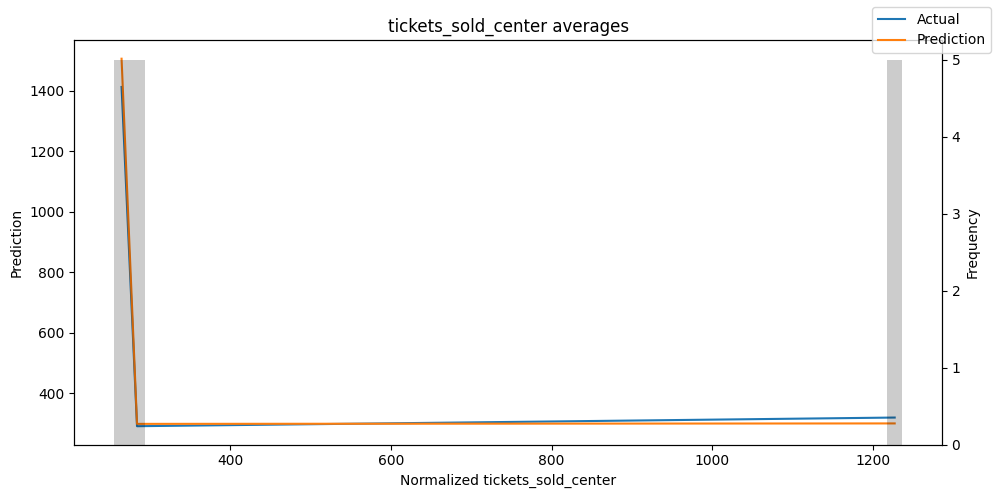

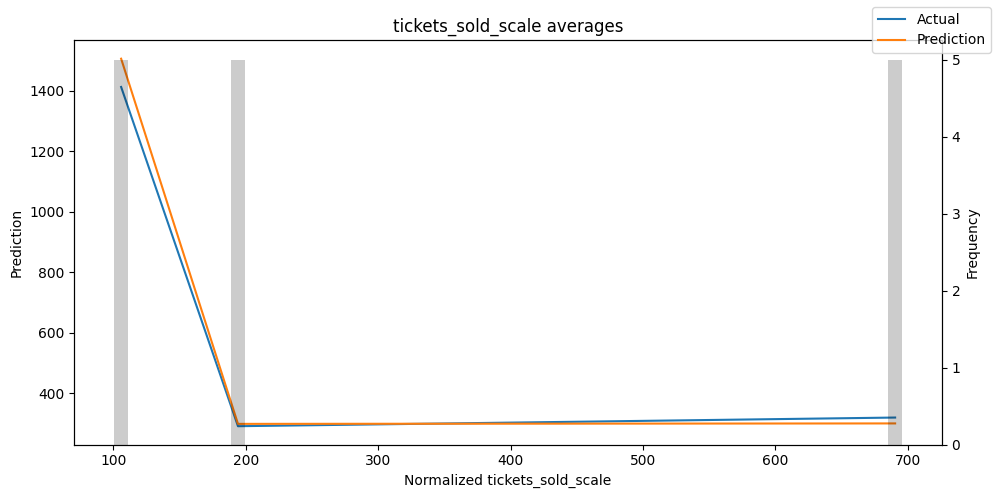

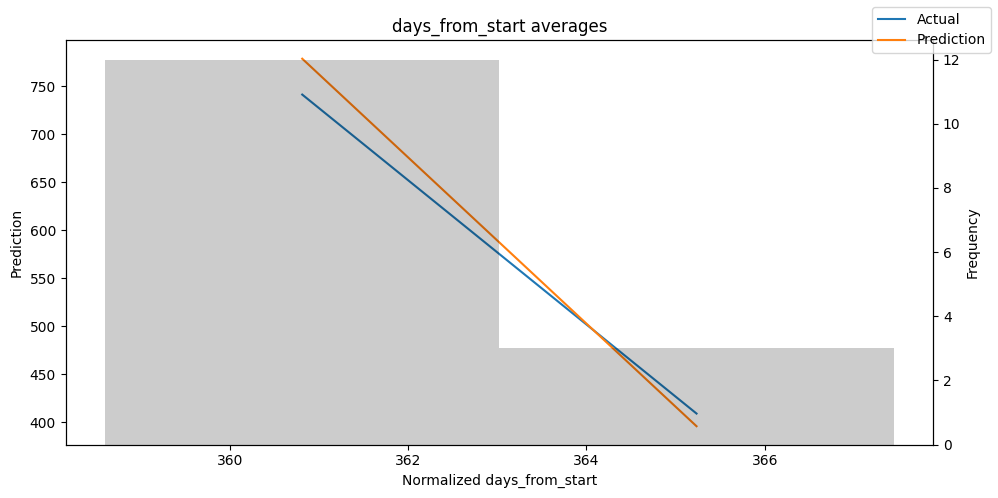

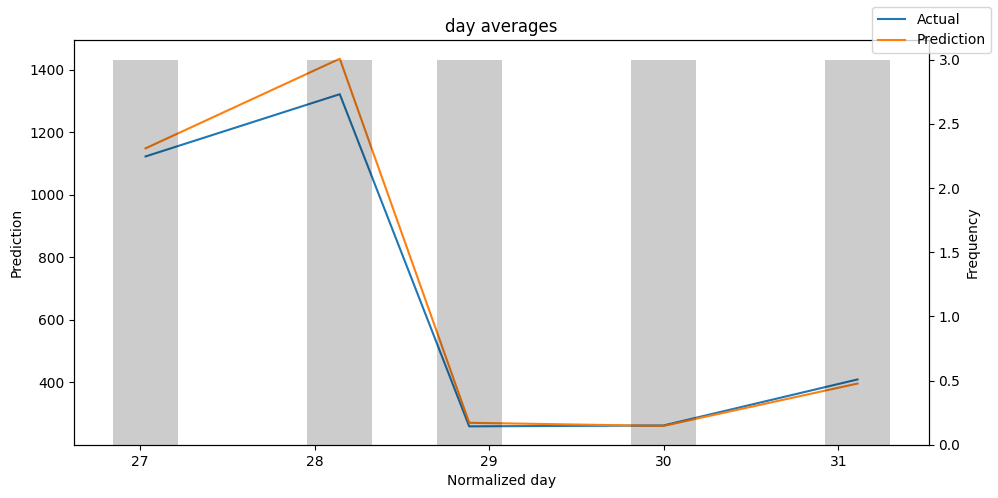

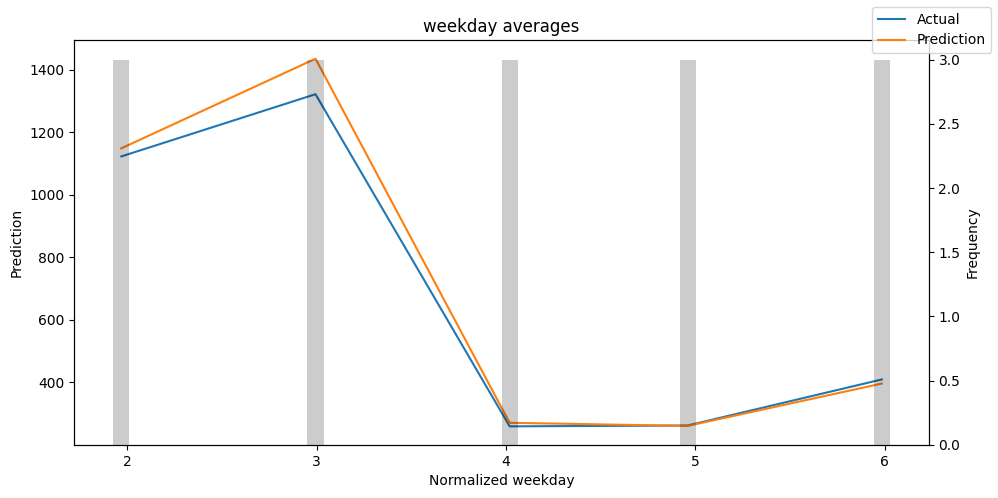

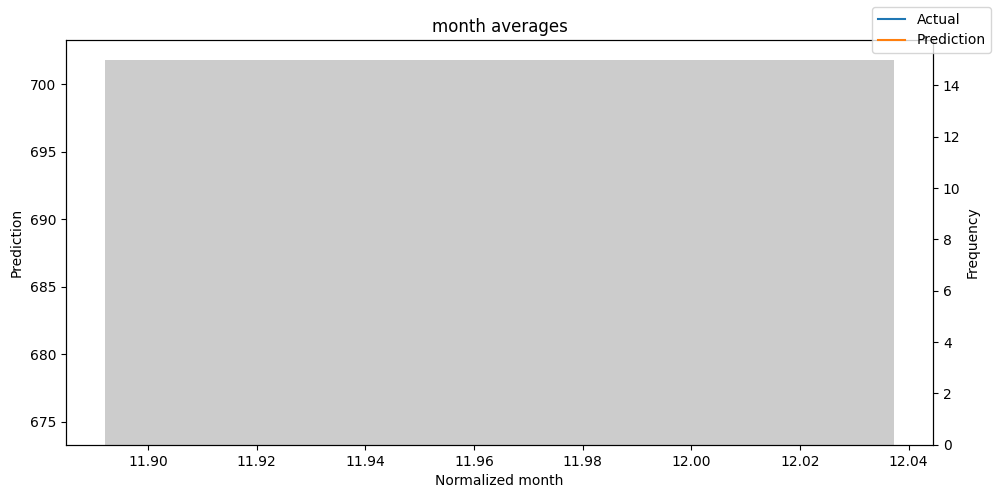

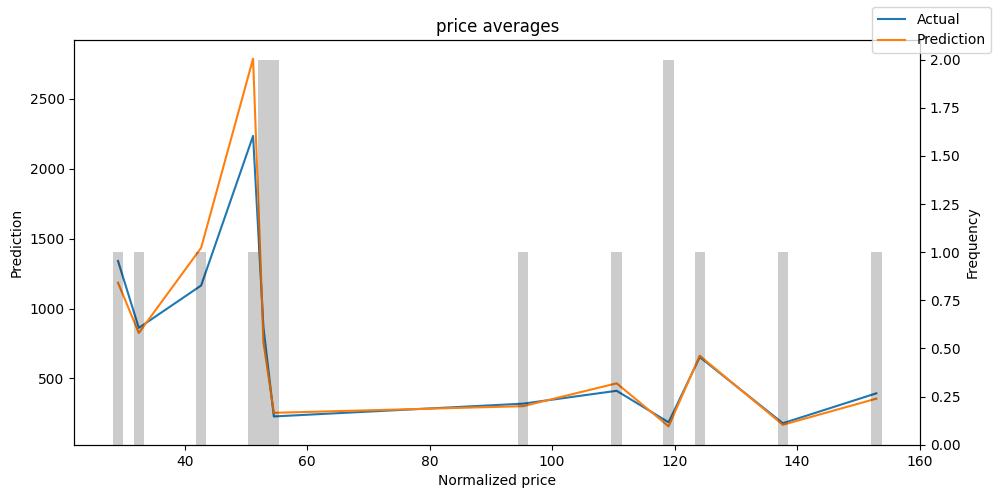

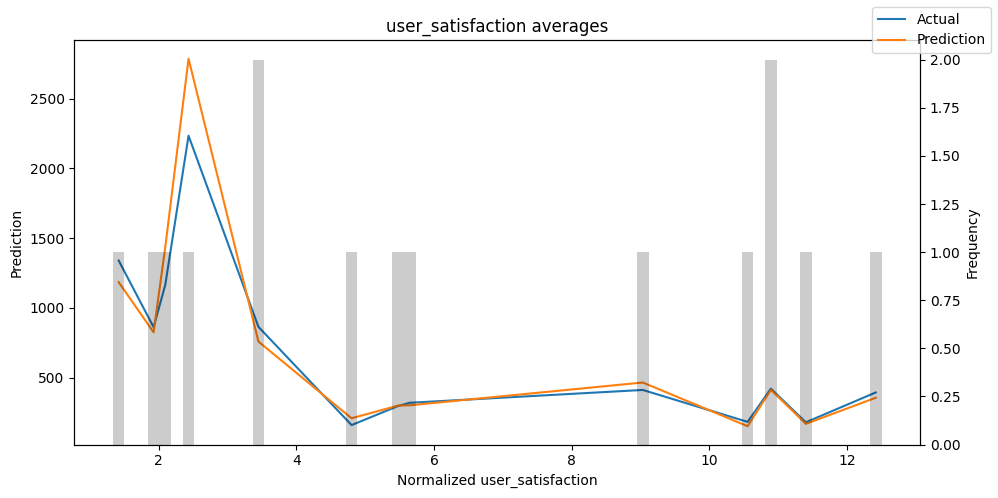

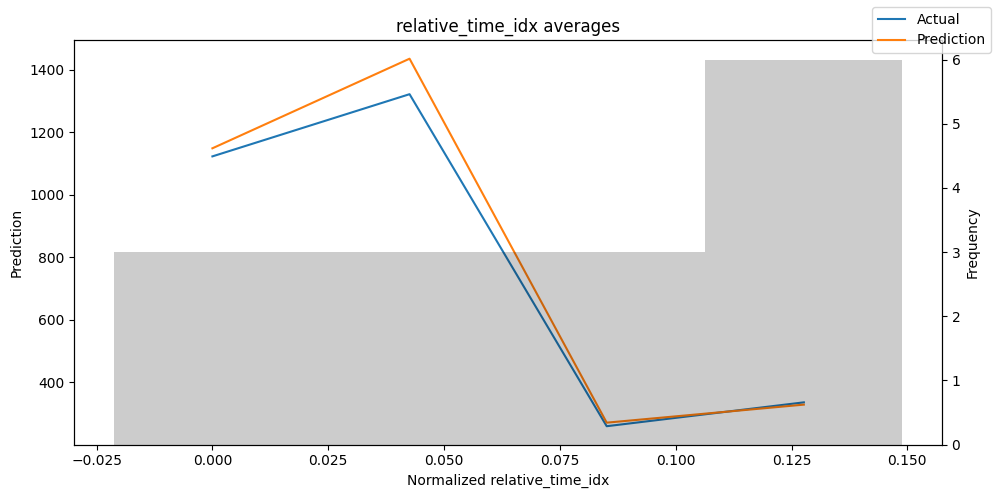

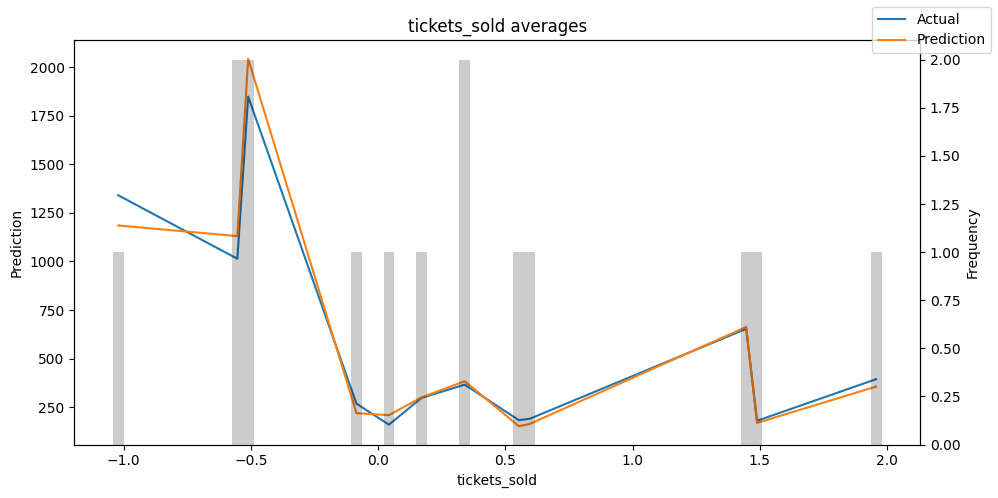

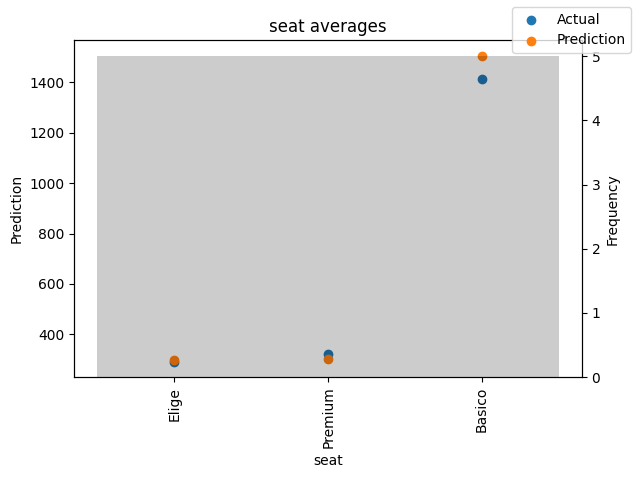

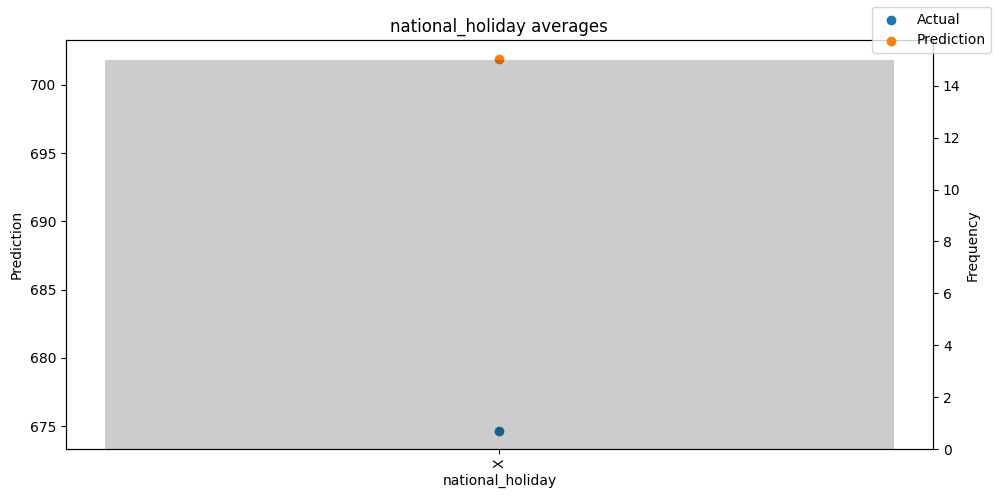

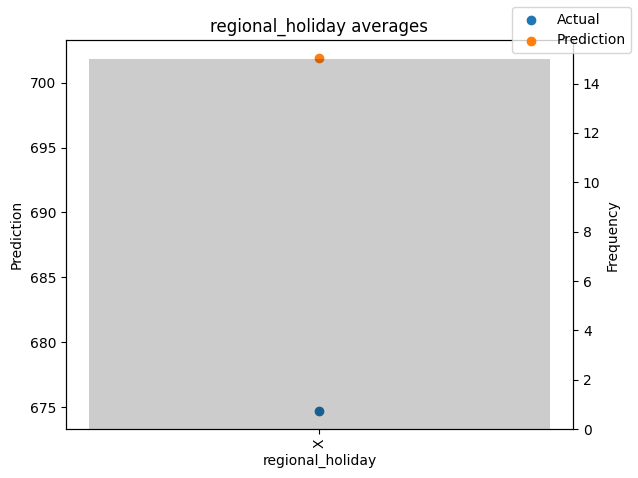

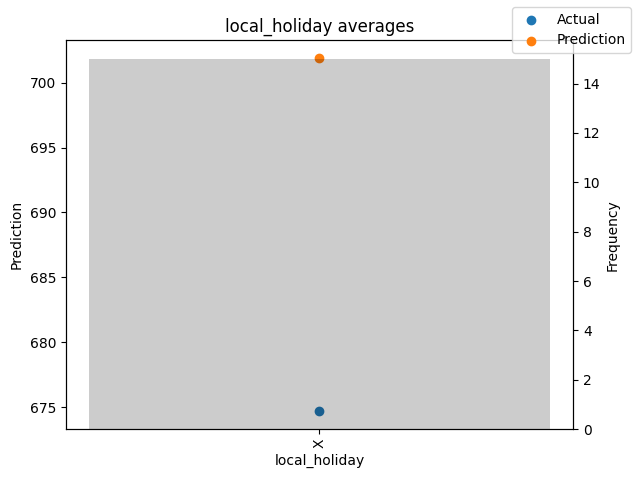

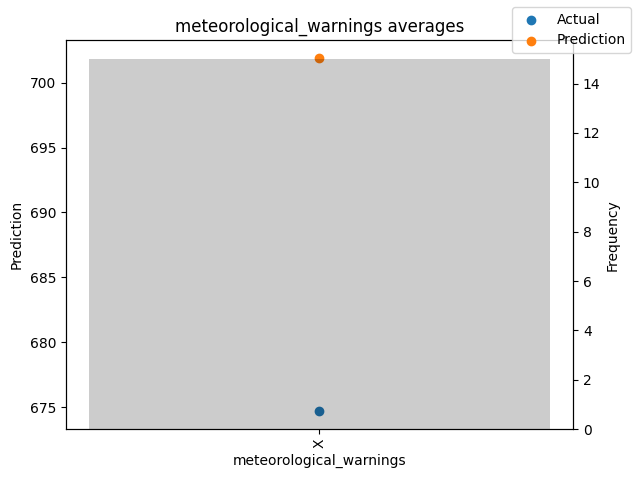

In [31]:
predictions = tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

Optimize the TFT hyperparameters

In [32]:
# create a new study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path='optuna_test',
    n_trials=50,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(32, 128),
    hidden_continuous_size_range=(32, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False 
)

# save study results
with open('test_study.pkl', 'wb') as fout:
    pickle.dump(study, fout)

# print best hyperparameters
print(study.best_trial.params)

[I 2023-05-26 13:01:21,586] A new study created in memory with name: no-name-474e3b42-01ff-4d17-908d-68a57e38b1f9
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:124: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:148: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Get the best TFT model

In [27]:
best_model_checkpoint = 'optuna_tft/trial_16/epoch=24.ckpt'

In [28]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_checkpoint)
best_tft

/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


TemporalFusionTransformer(
  	"attention_head_size":               3
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.28249093613560067
  	"embedding_labels":                  {'seat': {'Basico': 0, 'Elige': 1, 'Premium': 2}, 'national_holiday': {'Asunción de la Virgen': 0, 'Día de la Constitución Española': 1, 'Día de la Hispanidad': 2, 'Día del Trabajador': 3, 'Epifanía del Señor': 4, 'Jueves Santo': 5, 'La Inmaculada Concepción': 6, 'Todos los Santos': 7, 'Viernes Santo': 8, 'X': 9}, 'regional_holiday': {'Fiesta de la Comunidad de Madrid': 0, 'Lunes de Pascua': 1, 'San José': 2, 'Sant Joan': 3, 'X': 4}, 'local_holiday': {'Dilluns següent a la Mercè': 0, 'Día de Nuestra Señora de la Almudena': 1, 'Lunes de Pascua Granada': 2, 'San Isidro Labrador Patrón de Madrid': 3, 'X': 4}, 'meteorological_warnings': {'Orange': 0, 'X': 1}}
  	"embedding_paddings":                []
  	"embedding_sizes":               

In [29]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).cpu()
predictions = best_tft.predict(val_dataloader).cpu()
mae = mean_absolute_error(actuals, predictions)
print(f'Baseline MAE: {mae}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Baseline MAE: 67.92748260498047


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


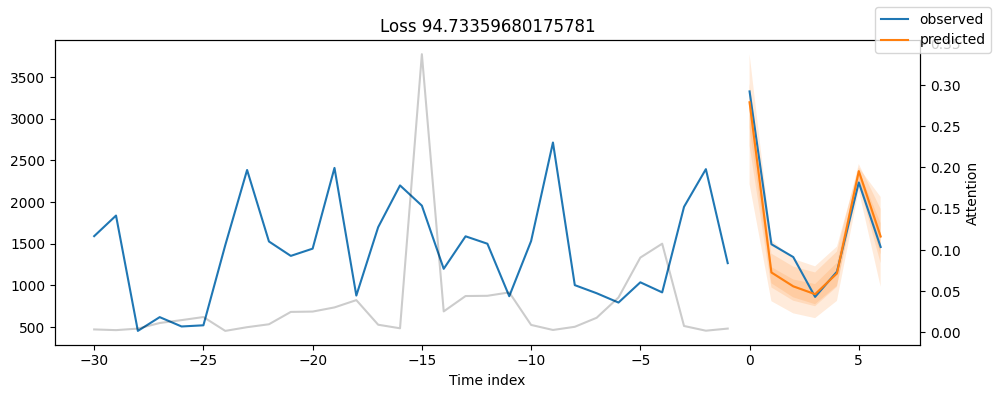

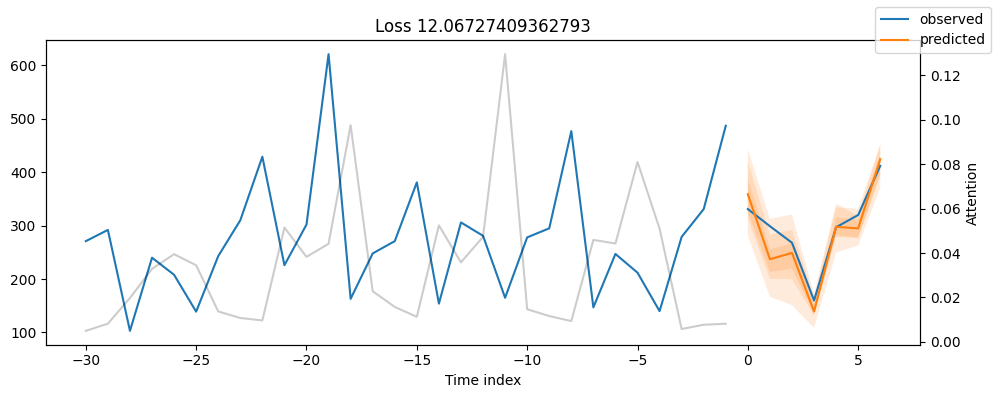

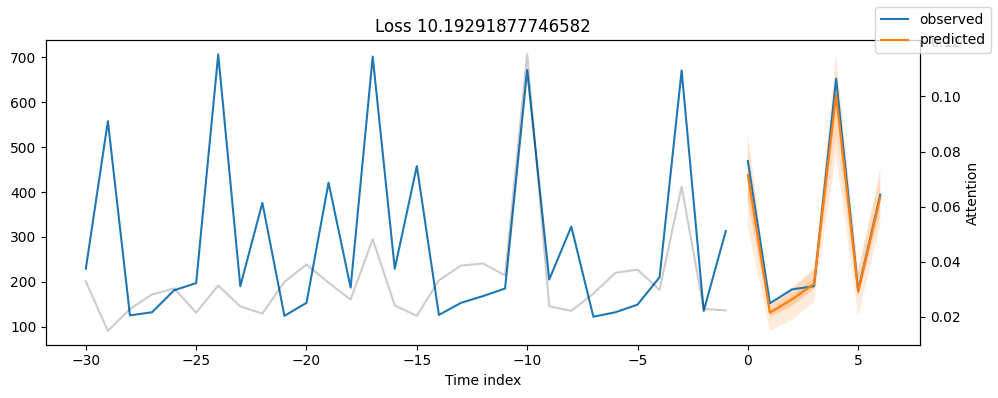

In [31]:
raw_predictions = best_tft.predict(val_dataloader, mode='raw', return_x=True)
for idx in range(3):
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True, ax=ax)
    fig.savefig(f'../reports/figures/renfe_tft/predictions_{idx}.svg', format='svg', bbox_inches='tight', transparent=True)

['seat', 'national_holiday', 'regional_holiday', 'local_holiday', 'meteorological_warnings', 'encoder_length', 'tickets_sold_center', 'tickets_sold_scale']
['days_from_start', 'day', 'weekday', 'month', 'price', 'user_satisfaction', 'relative_time_idx', 'tickets_sold']
['days_from_start', 'day', 'weekday', 'month', 'price', 'user_satisfaction', 'relative_time_idx']


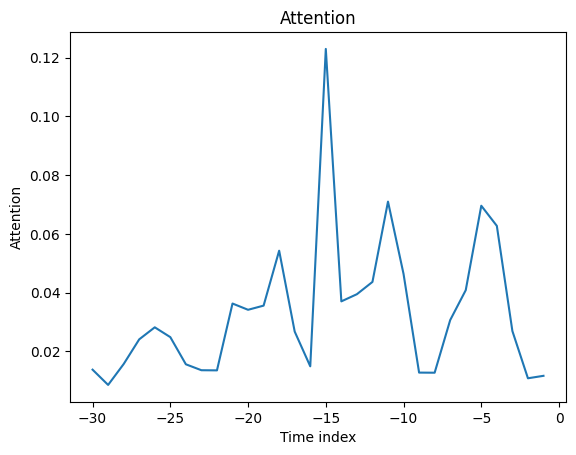

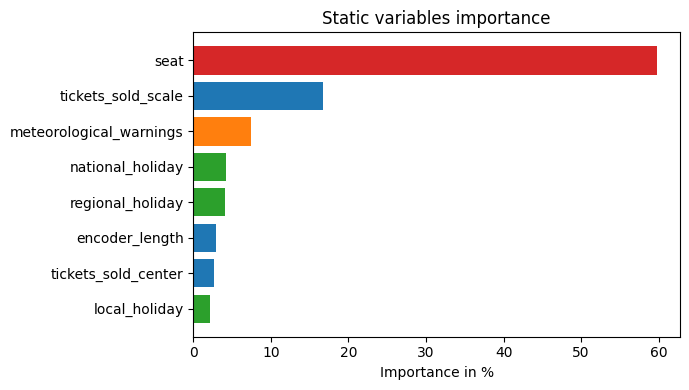

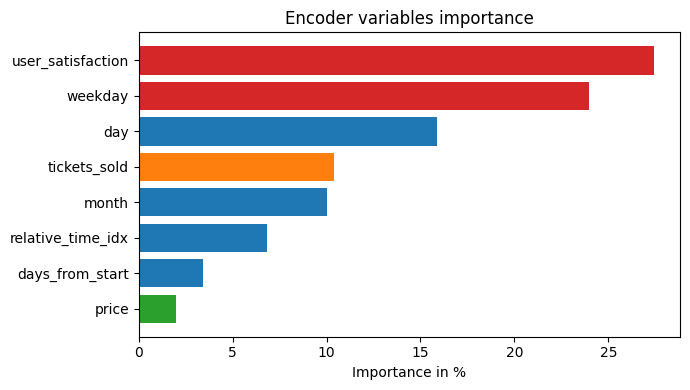

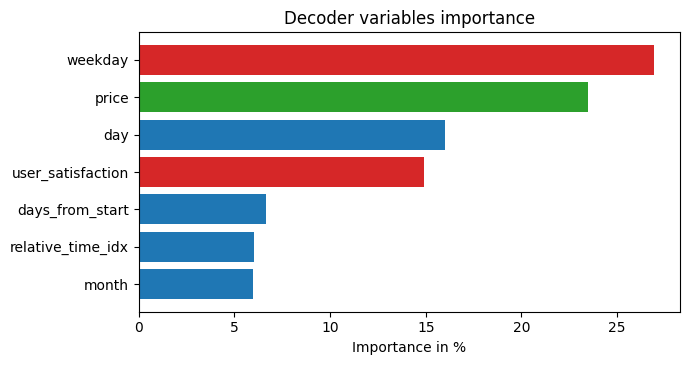

In [65]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction='sum')
figs = best_tft.plot_interpretation(interpretation)
for key, value in figs.items():
    value.savefig(f'../reports/figures/renfe_tft/interpretation_{key}.svg', format='svg', bbox_inches='tight', transparent=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


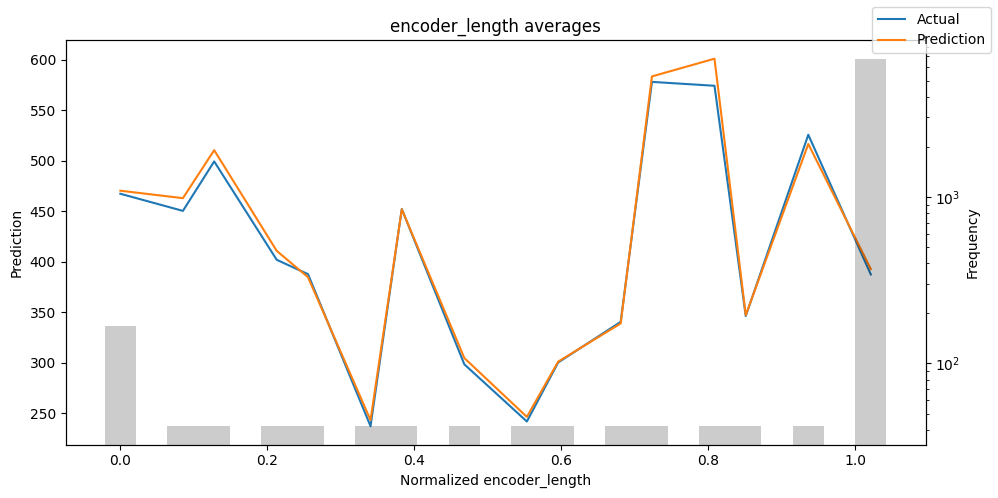

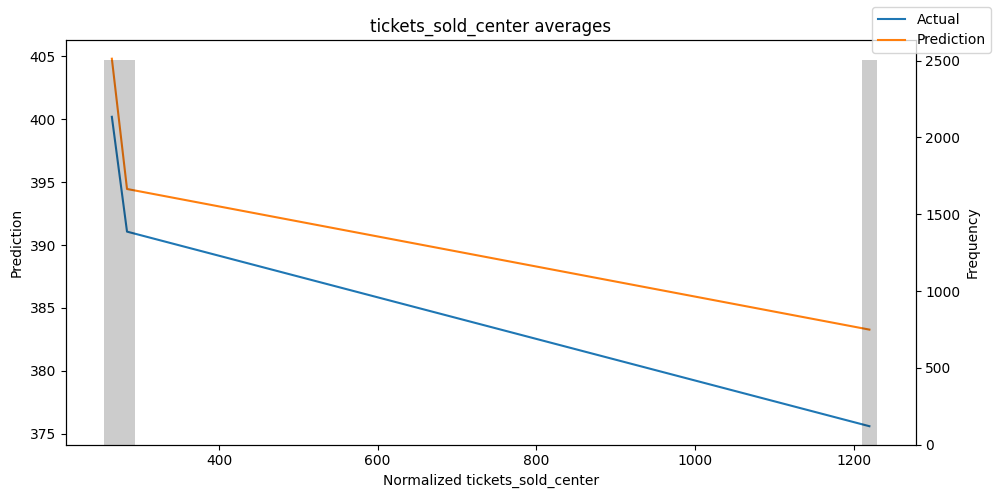

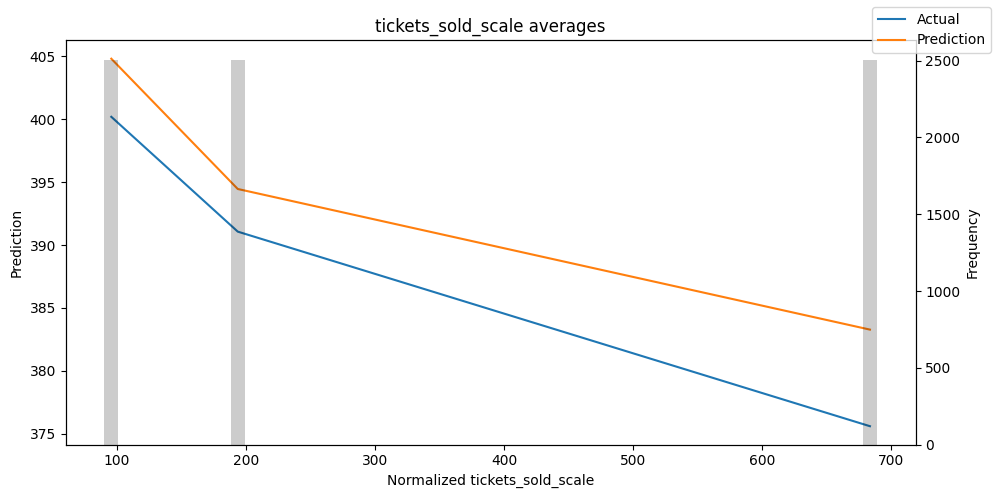

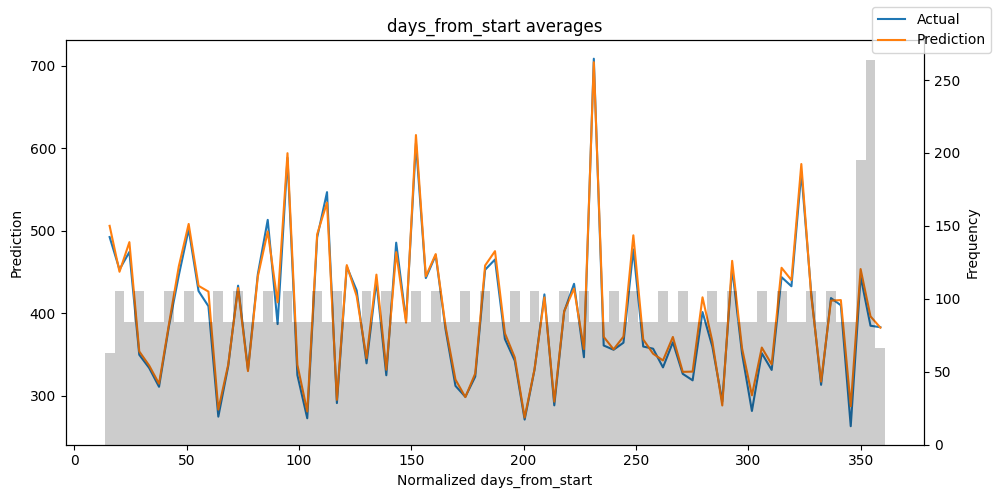

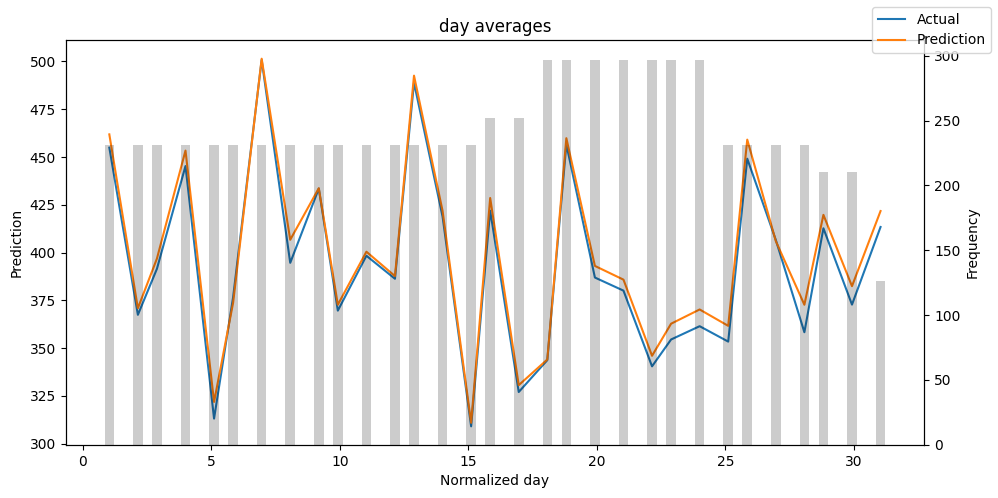

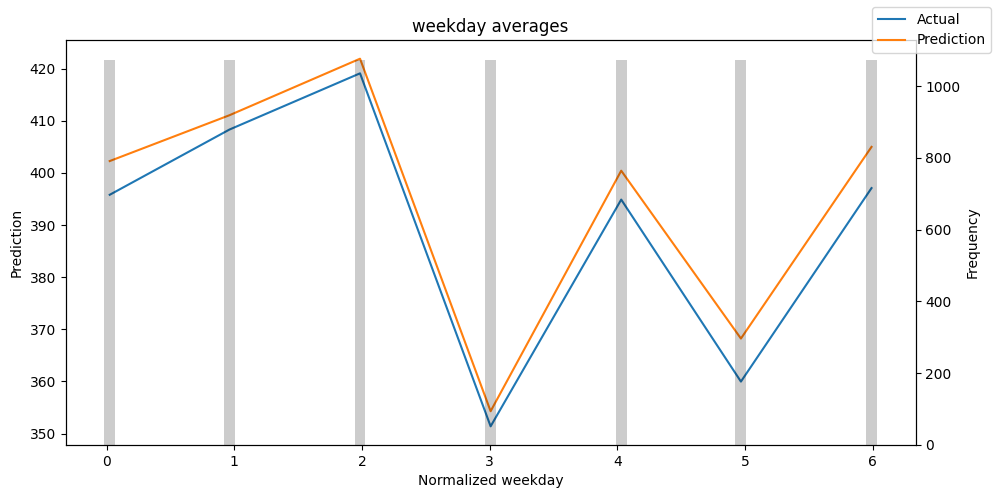

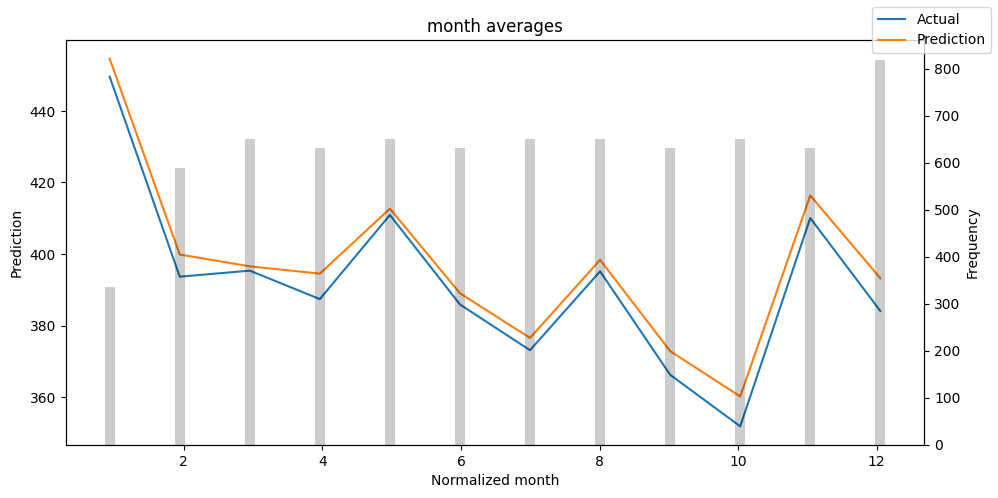

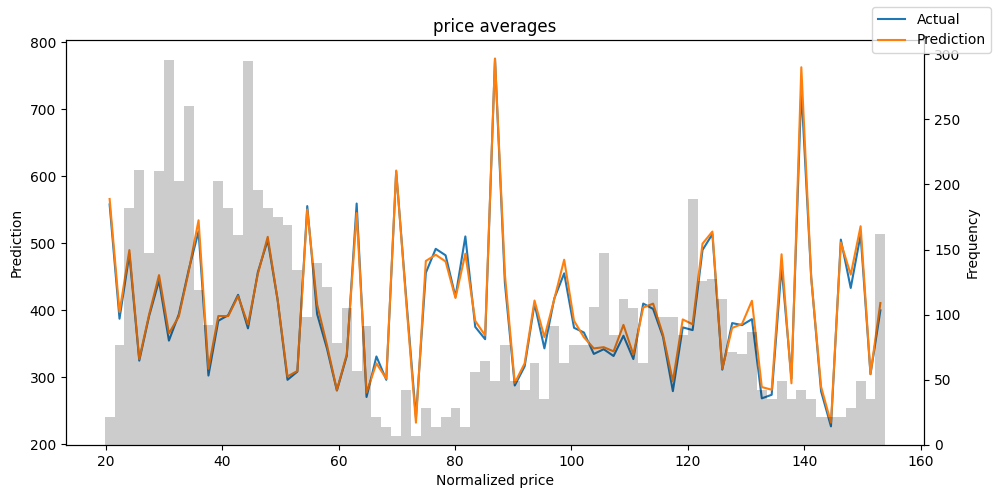

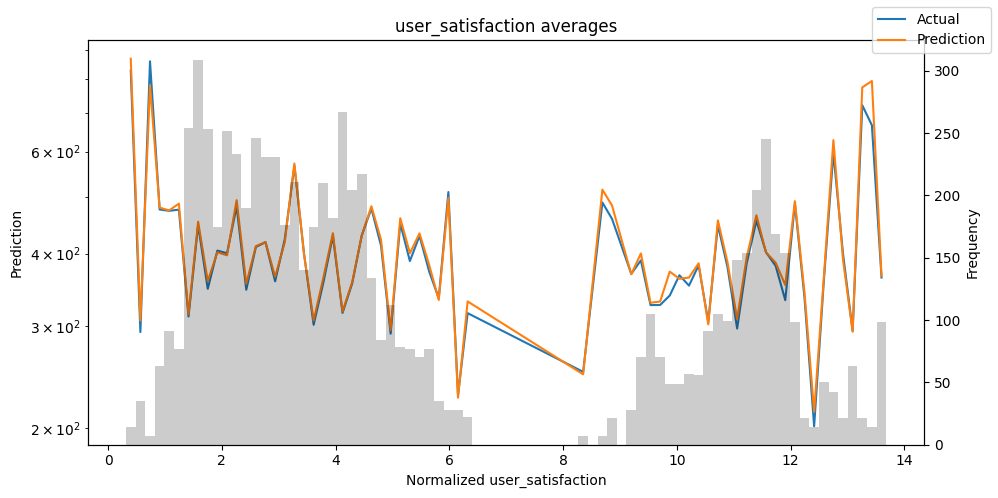

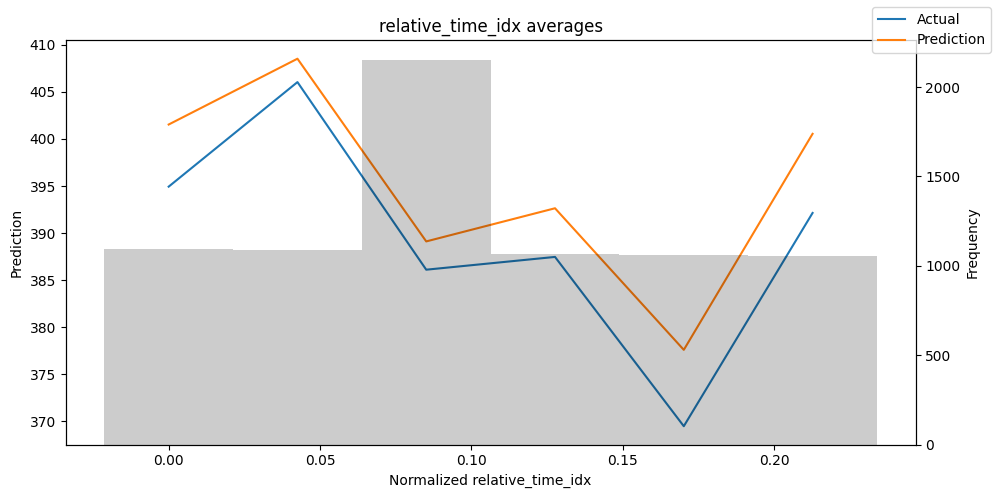

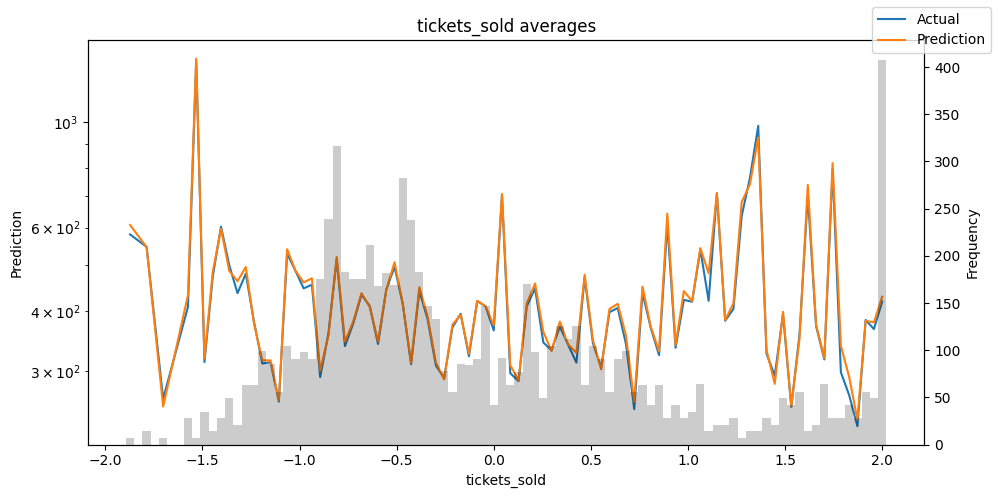

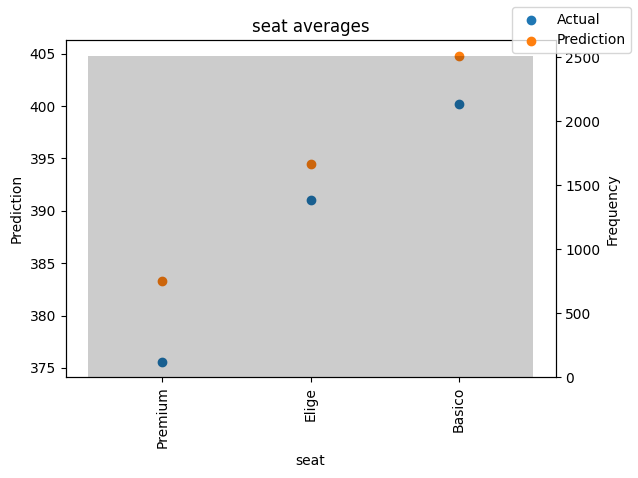

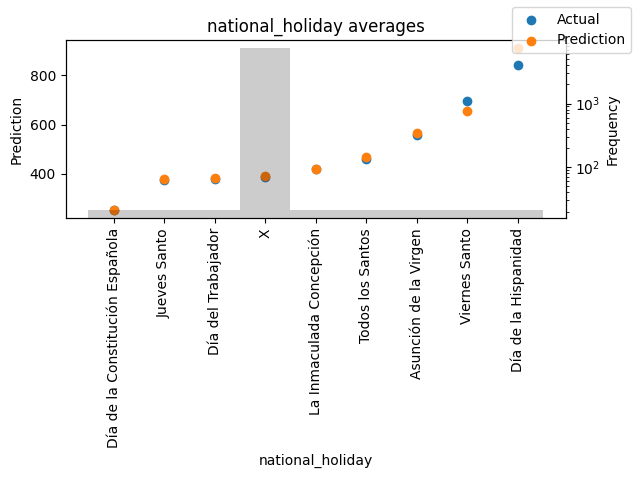

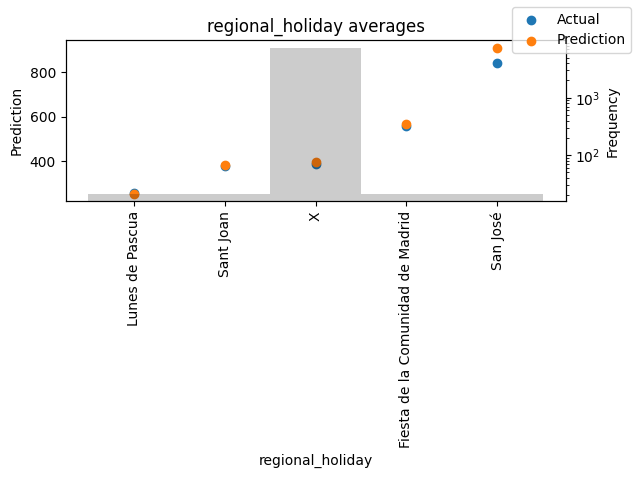

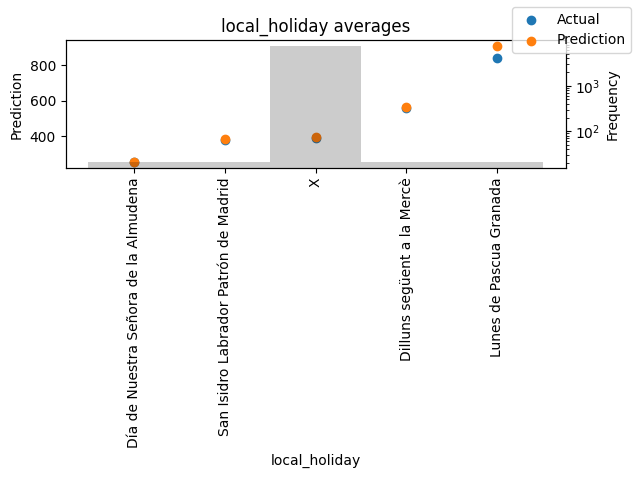

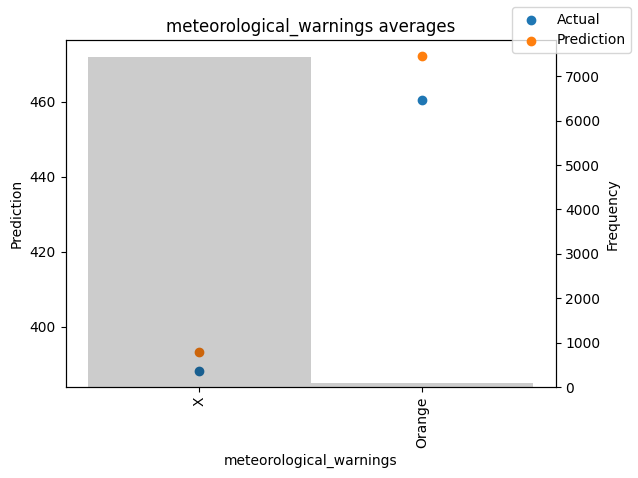

In [62]:
predictions = best_tft.predict(train_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
figs = best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)
for key, value in figs.items():
    value.savefig(f'../reports/figures/renfe_tft/prediction_actuals_{key}.svg', format='svg', bbox_inches='tight', transparent=True)